# load packages

In [1]:
import warnings
warnings.filterwarnings("ignore")
import logging
logging.basicConfig(level=logging.WARNING)
import os
import random
import importlib
importlib.invalidate_caches()
import tensorflow as tf
tf.compat.v1.reset_default_graph()
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)
import anndata as ad
import pandas as pd
import numpy as np
import scanpy as sc
from scipy.sparse import csr_matrix
from scipy.spatial import distance
from matplotlib.patches import Wedge
from matplotlib.collections import PatchCollection
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt
from AddaGCN import AddaGCN_API

def visualize_pie(proportion, spatial_location, colors=None, radius=None, seed=None):
    # Convert inputs to DataFrames
    res_results = pd.DataFrame(proportion)
    res_results = res_results.reindex(sorted(res_results.columns), axis=1)  # Equivalent to mixedsort
    
    location = pd.DataFrame(spatial_location)
    
    # Check if row names match
    if not res_results.index.equals(location.index):
        raise ValueError("The rownames of proportion data does not match with the rownames of spatial location data")
    
    # Define color candidates (same as in R code)
    colorCandidate = [
        "#1e77b4", "#ff7d0b", "#ceaaa3", "#2c9f2c", "#babc22", "#d52828", "#9267bc",
        "#8b544c", "#e277c1", "#d42728", "#adc6e8", "#97df89", "#fe9795", "#4381bd",
        "#f2941f", "#5aa43a", "#cc4d2e", "#9f83c8", "#91675a", "#da8ec8", "#929292",
        "#c3c237", "#b4e0ea", "#bacceb", "#f7c685", "#dcf0d0", "#f4a99f", "#c8bad8",
        "#F56867", "#FEB915", "#C798EE", "#59BE86", "#7495D3", "#D1D1D1", "#6D1A9C",
        "#15821E", "#3A84E6", "#997273", "#787878", "#DB4C6C", "#9E7A7A", "#554236",
        "#AF5F3C", "#93796C", "#F9BD3F", "#DAB370", "#877F6C", "#268785", "#f4f1de",
        "#e07a5f", "#3d405b", "#81b29a", "#f2cc8f", "#a8dadc", "#f1faee", "#f08080"
    ]
    
    # Handle colors
    if colors is None:
        if len(res_results.columns) > len(colorCandidate):
            # Create a color palette if needed
            cmap = plt.cm.get_cmap('Spectral')
            colors = [mcolors.rgb2hex(cmap(i)) for i in np.linspace(0, 1, len(res_results.columns))]
        else:
            if seed is not None:
                random.seed(seed)
            colors = random.sample(colorCandidate, len(res_results.columns))
    else:
        colors = colors
    
    # Combine data
    data = pd.concat([res_results, location], axis=1)
    ct_select = res_results.columns.tolist()
    
    # Calculate radius if not provided
    if radius is None:
        x_range = data['x'].max() - data['x'].min()
        y_range = data['y'].max() - data['y'].min()
        area = x_range * y_range
        radius = np.sqrt((area / len(data)) / np.pi) * 0.7
    else:
        radius = radius
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create pie charts for each point
    for idx, row in data.iterrows():
        x, y = row['x'], row['y']
        proportions = row[ct_select].values
        proportions = proportions / proportions.sum()  # Normalize
        
        # Calculate cumulative sums for wedge angles
        cumsum = np.cumsum(proportions)
        cumsum = np.insert(cumsum, 0, 0)
        
        # Create wedges
        wedges = []
        for i in range(len(proportions)):
            theta1 = cumsum[i] * 360
            theta2 = cumsum[i+1] * 360
            wedge = Wedge((x, y), radius, theta1, theta2, facecolor=colors[i])
            wedges.append(wedge)
        
        # Add wedges to plot
        pc = PatchCollection(wedges, match_original=True, edgecolor='none')
        ax.add_collection(pc)
    
    # Set aspect ratio
    ax.set_aspect('equal')
    
    # Set plot limits
    x_margin = (data['x'].max() - data['x'].min()) * 0.1
    y_margin = (data['y'].max() - data['y'].min()) * 0.1
    ax.set_xlim(data['x'].min() - x_margin, data['x'].max() + x_margin)
    ax.set_ylim(data['y'].min() - y_margin, data['y'].max() + y_margin)
    
    # Customize plot appearance
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Create legend
    legend_patches = [plt.Rectangle((0,0), 1, 1, fc=color) for color in colors]
    ax.legend(legend_patches, ct_select, title='Cell Type', 
              bbox_to_anchor=(1.05, 1), loc='upper left', 
              borderaxespad=0., frameon=False)
    
    plt.tight_layout()
    return fig, ax

2025-04-15 13:13:37.888720: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2025-04-15 13:13:37.895038: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:16:00.0 name: NVIDIA GeForce RTX 4090 computeCapability: 8.9
coreClock: 2.52GHz coreCount: 128 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 938.86GiB/s
2025-04-15 13:13:37.895174: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 1 with properties: 
pciBusID: 0000:34:00.0 name: NVIDIA GeForce RTX 4090 computeCapability: 8.9
coreClock: 2.52GHz coreCount: 128 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 938.86GiB/s
2025-04-15 13:13:37.895294: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 2 with properties: 
pciBusID: 0000:ac:00.0 name: NVIDIA GeForce RTX 4090 computeCapability: 8.9
coreClock: 2.52GHz coreCount: 128 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 9

# load Data
This tutorial demonstrates AddaGCN's ablility to accurate and robust decomposition of cell-type compositions in the developing human heart dataset.

In this tutorial, the spatial transcriptomic data and single-cell data of the developing human heart were acquired from https://www.spatialresearch.org/resources-published-datasets/doi-10-1016-j-cell-2019-11-025/. 

ISS data are available at https://doi.org/10.6084/m9.figshare.10058048.v1.

In [ ]:
input_dir = os.path.join('../AddaGCN')
os.chdir(input_dir)

ST data preprocessing

In [ ]:
counts_sp = pd.read_csv('Data/Human_Heart_Develop/Filtered/filtered_ST_matrix_and_meta_data/filtered_matrix.tsv', index_col=0, sep='\t').T
genes = counts_sp.columns.tolist()  
processed_genes = [gene.split('.')[0] for gene in genes]  
counts_sp.columns = processed_genes

sp_ens2gene = pd.read_csv("Data/Human_Heart_Develop/single/ens2symbol.txt", sep=' ', header=None, index_col=0)  # 210
sp_ens2gene.columns = ['gene']
counts_sp_ = counts_sp[sp_ens2gene.index.tolist()]
counts_sp_.columns =  sp_ens2gene['gene']
adata_all = ad.AnnData(counts_sp_)
meta_sp = pd.read_csv('Data/Human_Heart_Develop/Filtered/filtered_ST_matrix_and_meta_data/meta_data.tsv', index_col=0, sep='\t')
adata_all.obs = meta_sp

original_strings = adata_all.obs['Sample'].tolist() 
first_parts = []  
for s in original_strings:  
    first_part = s.split('_', 1)[0]  
    first_parts.append(first_part) 
adata_all.obs['sample'] = first_parts
# 
list_data = adata_all.obs_names.tolist()
parts1 = []  
parts2 = []  
for item in list_data:  
    parts = item.split('x')  
    parts1.append(parts[1])
    parts2.append(parts[2])
adata_all.obs['cood_x'] = parts1 
adata_all.obs['cood_y'] = parts2

# 
adata_all.obsm['spatial'] = adata_all.obs[['new_x', 'new_y']].values
adata_all.var_names_make_unique()
slice_list = adata_all.obs['Sample'].unique().tolist()

adata_all.write_h5ad('../Data/Human_Heart_Develop/adata_sp.h5ad')

ISS data preprocessing

In [ ]:
iss_PCW65_2 = pd.read_csv('Data/Human_Heart_Develop/ISS/cell_calling_PCW6.5_2.csv', index_col=0)  
iss_PCW65_2 = iss_PCW65_2[iss_PCW65_2['celltype'] != 'Uncalled'] 

iss_w_PCW65_2 = pd.read_csv('Data/Human_Heart_Develop/ISS/spots_w_cell_segmentation_PCW6.5_2.csv', index_col=0)  
gene_list = iss_w_PCW65_2.index.unique().tolist()

iss_w_PCW65_2 = iss_w_PCW65_2[iss_w_PCW65_2['parent_id'] != 0]
parent_id = iss_w_PCW65_2['parent_id'].unique().tolist()
parent_rank = sorted(parent_id)

# expression
df = pd.DataFrame(0, index=iss_PCW65_2.index, columns=gene_list)  
spatial = []
for id_ in range(len(parent_rank)):
    exp = iss_w_PCW65_2[iss_w_PCW65_2['parent_id'] == parent_rank[id_]]
    loc = np.mean(exp[['spotX', 'spotY']].values, axis=0).tolist()
    spatial.append(loc)
    for gene in exp.index.tolist():
        df.loc[parent_rank[id_]][gene] = df.loc[parent_rank[id_]][gene] + 1

adata_sp = ad.AnnData(df)
adata_sp.obsm['spatial'] = np.array(spatial)

data = adata_sp.obsm['spatial']
y_min, y_max = data[:, 1].min(), data[:, 1].max()   
data_flipped = np.array([[x, y_max - (y - y_min)] for x, y in data]) 
adata_sp.obsm['spatial'] = data_flipped

data = data_flipped  
x_min, x_max = data[:, 0].min(), data[:, 0].max()  
data_flipped_x = np.array([[2 * x_max - x, y] for x, y in data])  
adata_sp.obsm['spatial'] = data_flipped_x 

cell_index = [f'cell_{num}' for num in adata_sp.obs_names.tolist()]
adata_sp.obs_names = cell_index
iss_PCW65_2.index = cell_index

iss_PCW65_2.columns = ['celltype', 'Capillary_endothelium', 'Ventricular_cardiomyocytes', 'Fibroblast_like_1', 'Epicardial_cells', 
                       'Fibroblast_like_2', 'Smooth_muscle_cells',  'Atrial_cardiomyocytes', 'Fibroblast_like_3',
                       'Epicardium_derived_cells', 'Endothelium_pericytes_adventitia',
                       'Myoz2_enriched_cardiomyocytes', 'Cardiac_neural_crest_cells', 'Zero']
adata_sp.obs = iss_PCW65_2
adata_sp.write_h5ad('../Data/Human_Heart_Develop/ISS_PCW6.5_2.h5ad')

sc data preprocessing

In [ ]:
counts_sc = pd.read_csv('Data/Human_Heart_Develop/single/all_cells_count_matrix_filtered.tsv', index_col=0, sep='\t').T
adata_sc = ad.AnnData(counts_sc)
adata_sc.X = csr_matrix(adata_sc.X)
sc_meta = pd.read_csv('Data/Human_Heart_Develop/single/sc_meta.txt', sep='\t',index_col=0, header=None)
sc_meta.columns = ['id_label', 'celltype']
set(adata_sc.obs_names == sc_meta.index)
adata_sc.obs['cellType'] = sc_meta['celltype'].values
print(adata_sc.obs['cellType'].unique())
adata_sc.var_names_make_unique()
print(len(adata_sc.obs['cellType'].unique()))
adata_sc.write_h5ad('../Data/Human_Heart_Develop/adata_sc.h5ad')

In [2]:
adata_sp = ad.read_h5ad('Data/Human_Heart_Develop/adata_sp.h5ad')
slice_list = adata_sp.obs['Sample'].unique().tolist()
section_id = slice_list[12]
adata_sp = adata_sp[adata_sp.obs['Sample'] == section_id].copy()
# sc data
adata_sc = ad.read_h5ad('Data/Human_Heart_Develop/adata_sc.h5ad')

inter_gene = list(set(adata_sp.var_names)&set(adata_sc.var_names))
adata_sp = adata_sp[:,inter_gene]
adata_sc = adata_sc[:,inter_gene]

# train model

In [3]:
AddaGCN = AddaGCN_API(adata_sp, adata_sc, num_markers=20, 
                      n_samples=1000,  nmix=8, 
                      sample_iter = 1,  ct_unm_fix = 2,
                      celltype = 'cellType', sp= 'spatial')
AddaGCN.Train_(loss_weight = [0.1, 1], epochs=1000, lr=[0.001,0.001], 
               initial_train_epochs=10, emb_dim=64,
               initial_train = True,enable_dann = True)

... marker gene ...
42148628 (3777, 14327)
37229884.0 (3777, 14327)
10953678.0 (3777, 14327)
-121595.66 (3777, 14327)
... pseudo ...
... Pseudo number ...
Fixed number : 750
Unfixed number : 250
73955 (180, 264)
70110.0 (180, 264)
20219.488 (180, 264)
-4.2543335 (180, 264)
1599519.92619082 (1000, 264)
1501125.0 (1000, 264)
283906.2343374618 (1000, 264)
-1.7053025658242404e-12 (1000, 264)
... Graph ...
------Calculating spatial graph...
... Calculating A matrix ...
<class 'numpy.matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'numpy.ndarray'>


2025-04-14 21:38:29.739485: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2025-04-14 21:38:29.785759: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 1896000000 Hz
2025-04-14 21:38:29.814807: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0578000b70 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-04-14 21:38:29.814844: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-04-14 21:38:29.945651: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x64806b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-14 21:38:29.945729: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-04-14 21:38:29.946778: I tensorf

initial_train_done
Epoch: 0000 train_loss= 2.6929 train_acc= 0.3864 val_loss= 2.6927 val_acc= 0.3333 test_loss= 2.6911 test_acc= 0.3500 time= 0.6936
Epoch: 0200 train_loss= 2.2787 train_acc= 0.6975 val_loss= 2.3588 val_acc= 0.5778 test_loss= 2.2235 test_acc= 0.7500 time= 0.1879
Epoch: 0400 train_loss= 2.2091 train_acc= 0.7667 val_loss= 2.3140 val_acc= 0.6444 test_loss= 2.1601 test_acc= 0.8100 time= 0.1671
Epoch: 0600 train_loss= 2.1670 train_acc= 0.7963 val_loss= 2.2751 val_acc= 0.6778 test_loss= 2.1310 test_acc= 0.8700 time= 0.1356
Epoch: 0800 train_loss= 2.1258 train_acc= 0.8123 val_loss= 2.2399 val_acc= 0.7444 test_loss= 2.1053 test_acc= 0.8800 time= 0.1828


# point plot

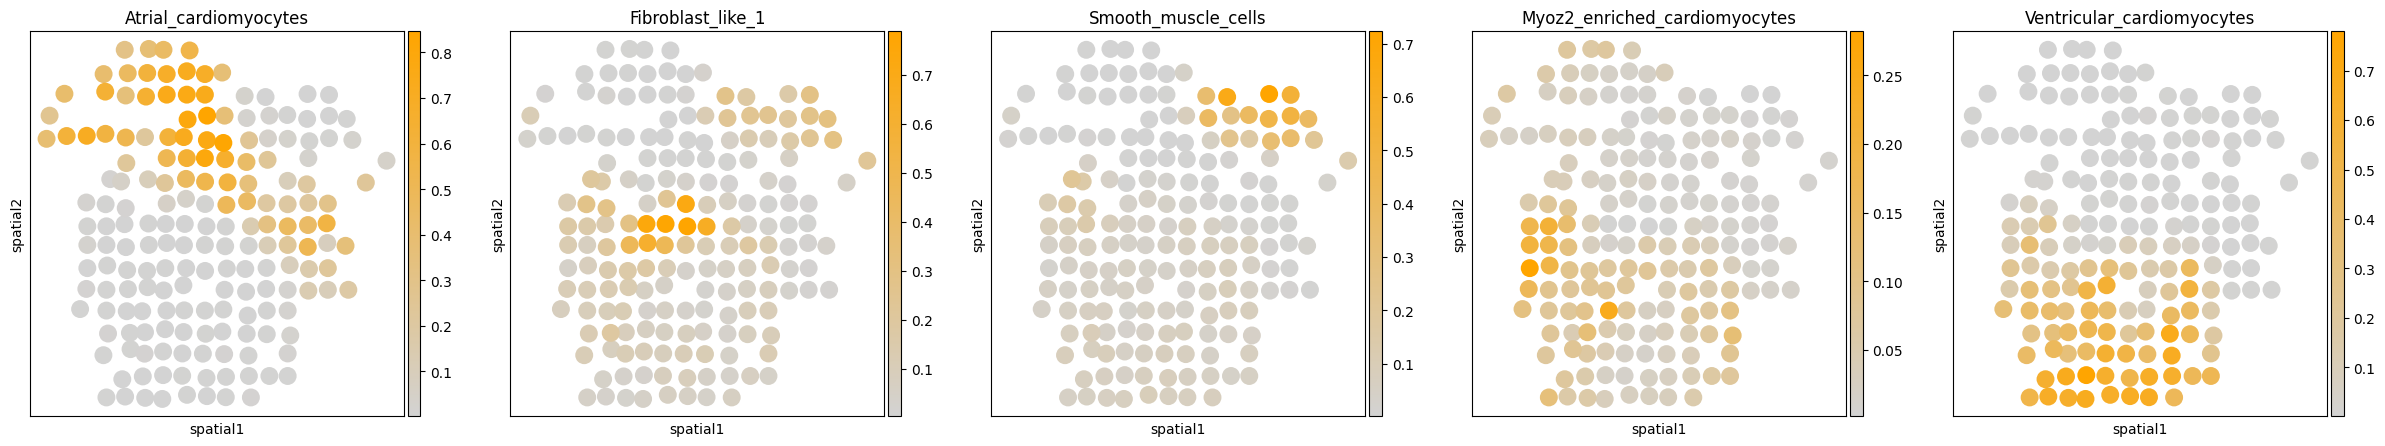

In [4]:
adata_pseudo = AddaGCN.adata_pseudo.copy()
adata_sp = AddaGCN.adata_sp.copy()

label = list(adata_pseudo.obsm['pred_label'].columns)
pred_real = adata_sp.obs[label]

adata_sp.obs = pred_real
label = ['Atrial_cardiomyocytes',  'Fibroblast_like_1', 'Smooth_muscle_cells', 'Myoz2_enriched_cardiomyocytes', 'Ventricular_cardiomyocytes']
from matplotlib.colors import LinearSegmentedColormap  
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["lightgray", "orange"]) 
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.embedding(adata_sp,   
                color=label,   
                basis='spatial',   
                cmap=cmap,     
                ncols=5,  
                return_fig=False) 

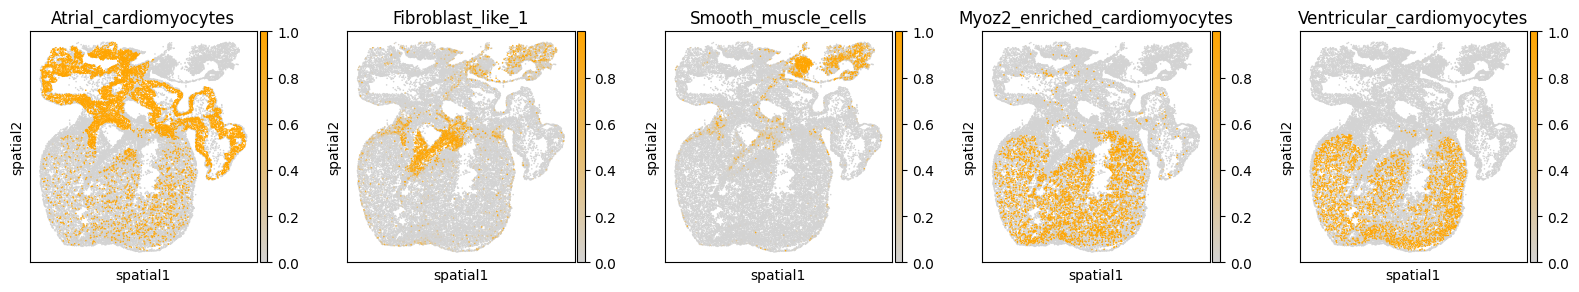

In [5]:
# ISS
adata_sp = ad.read_h5ad('Data/Human_Heart_Develop/ISS_PCW6.5_2.h5ad')
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(adata_sp,   
                color=label,   
                basis='spatial',   
                cmap=cmap,     # 使用自定义颜色映射  
                ncols=6,  
                size=5,
                return_fig=False)  
plt.show()

# pie plot

In [6]:
adata_pseudo = AddaGCN.adata_pseudo.copy()
adata_sp = AddaGCN.adata_sp.copy()
label = ['Capillary_endothelium','Ventricular_cardiomyocytes','Fibroblast_like_1','Epicardial_cells','Fibroblast_like_2',
         'Smooth_muscle_cells','Atrial_cardiomyocytes','Fibroblast_like_3','Epicardium_derived_cells','Endothelium_pericytes_adventitia',
         'Myoz2_enriched_cardiomyocytes','Cardiac_neural_crest_cells']
pred_real = adata_sp.obs[label]

location = pd.DataFrame(AddaGCN.adata_sp.obsm['spatial'])
pred_real.index = location.index
location.columns = ['x', 'y']

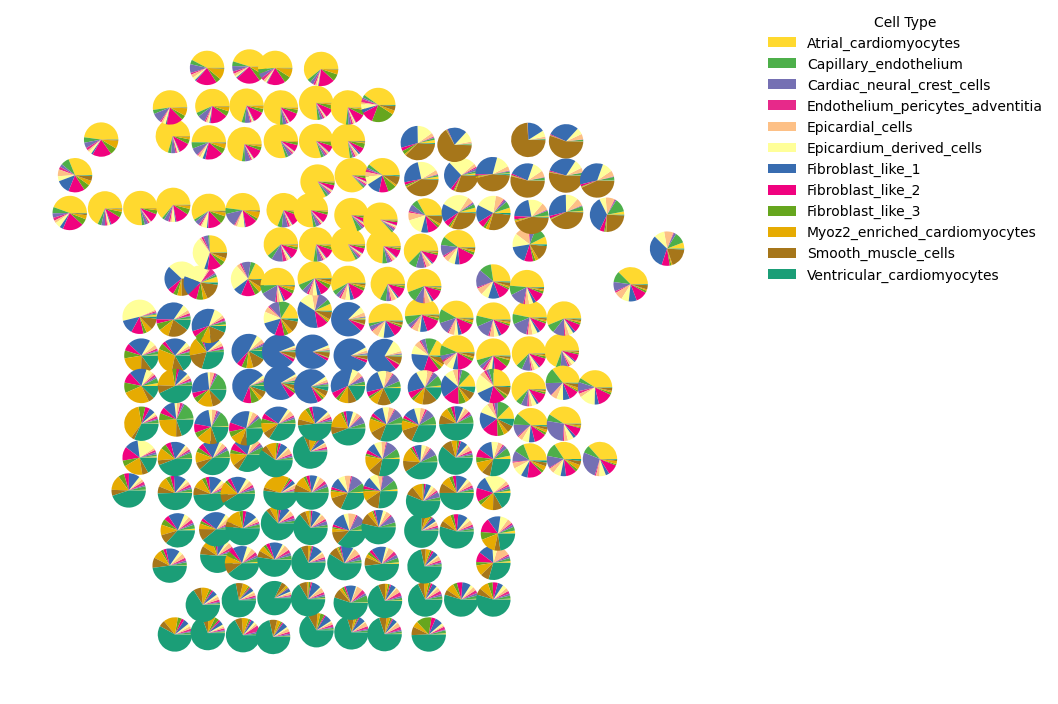

In [7]:
coler_len = len(pred_real.columns)
colors = ["#FFD92F","#4DAF4A","#7570B3","#E7298A","#FDC086", "#FFFF99","#386CB0","#F0027F","#66A61E",
           "#E6AB02","#A6761A" ,"#1B9E77","#D95F02","#9E0142","#D53E4F", "#FCCDE5","#D9D9D9",
           "#377EB8","#7FC97F","#BEAED4", "#BF5B17","#666666"]


fig, ax = visualize_pie(pred_real, location, colors[:coler_len])
plt.show()